# Binary classification
---------------------------------

This example shows how we can use ATOM to perform a variety of data cleaning steps in order to prepare the data for modelling. Then, we compare the prediction performance of an Extra-Trees and a Random Forest.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binay classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from sklearn.metrics import fbeta_score
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv('./datasets/weatherAUS.csv')

# Let's have a look at a subset of the data
X.sample(frac=1).iloc[:5, :8]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed
68369,Mildura,3.9,18.5,0.0,2.0,9.4,NE,28.0
7510,Cobar,2.9,15.9,0.2,2.0,NaN,ENE,19.0
13009,Moree,13.8,31.3,0.0,9.2,11.2,N,37.0
485,Albury,13.5,23.1,3.2,NaN,NaN,NW,46.0
53030,MountGinini,0.9,10.4,0.0,NaN,NaN,NW,24.0


## Run the pipeline

In [3]:
# Call ATOM using only 5% of the complete dataset (for explanatory purposes)
atom = ATOMClassifier(X, y='RainTomorrow', n_rows=0.05, n_jobs=8, warnings=False, verbose=2, random_state=1)

<< ================== ATOM ================== >>
Algorithm task: binary classification.
Parallel processing with 8 cores.
Applying data cleaning...

Dataset stats ================= >>
Shape: (7110, 22)
Missing values: 15896
Categorical columns: 5
Scaled: False
----------------------------------
Train set size: 5688
Test set size: 1422
----------------------------------
Train set balance: No:Yes <==> 3.7:1.0
Test set balance: No:Yes <==> 4.1:1.0
----------------------------------
Instances in RainTomorrow per class:
|        |    total |    train_set |    test_set |
|:-------|---------:|-------------:|------------:|
| 0: No  |     5615 |         4473 |        1142 |
| 1: Yes |     1495 |         1215 |         280 |



In [4]:
# We can change the data properties in the pipeline
# Note that we can only replace the property with a new df
new_train = atom.X
new_train.insert(loc=3, column='AvgTemp', value=(atom.X['MaxTemp'] + atom.X['MinTemp'])/2)
atom.X = new_train

# This will automatically update all other data properties
assert 'AvgTemp' in atom.dataset

In [5]:
# Impute missing values
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Dropping 778 rows for containing less than 80% non-missing values.
 --> Imputing 5 missing values using the KNN imputer in feature MinTemp.
 --> Imputing 3 missing values using the KNN imputer in feature MaxTemp.
 --> Imputing 8 missing values using the KNN imputer in feature AvgTemp.
 --> Imputing 31 missing values using the KNN imputer in feature Rainfall.
 --> Imputing 2314 missing values using the KNN imputer in feature Evaporation.
 --> Imputing 2645 missing values using the KNN imputer in feature Sunshine.
 --> Imputing 201 missing values with remove in feature WindGustDir.
 --> Imputing 199 missing values using the KNN imputer in feature WindGustSpeed.
 --> Imputing 365 missing values with remove in feature WindDir9am.
 --> Imputing 24 missing values with remove in feature WindDir3pm.
 --> Imputing 4 missing values using the KNN imputer in feature WindSpeed9am.
 --> Imputing 3 missing values using the KNN imputer in feature Wind

In [6]:
# Encode the categorical features
atom.encode(max_onehot=10, frac_to_other=0.04)

Fitting Encoder...
Encoding categorical columns...
 --> Target-encoding feature Location. Contains 1 unique categories.
 --> Target-encoding feature WindGustDir. Contains 17 unique categories.
 --> Target-encoding feature WindDir9am. Contains 17 unique categories.
 --> Target-encoding feature WindDir3pm. Contains 17 unique categories.
 --> One-hot-encoding feature RainToday. Contains 3 unique categories.


In [7]:
# Perform undersampling of the majority class
atom.balance(oversample=None, undersample=0.9)
atom.stats()  # Note the balanced training set

Performing undersampling...
 --> Removing 2797 rows from category: No.

Dataset stats ================= >>
Shape: (3535, 25)
Scaled: False
----------------------------------
Train set size: 2269
Test set size: 1266
----------------------------------
Train set balance: No:Yes <==> 1.1:1.0
Test set balance: No:Yes <==> 4.1:1.0
----------------------------------
Instances in RainTomorrow per class:
|        |    total |    train_set |    test_set |
|:-------|---------:|-------------:|------------:|
| 0: No  |     2211 |         1194 |        1017 |
| 1: Yes |     1324 |         1075 |         249 |



In [8]:
# Define a custom metric
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# Fit the EXtra-Trees and Random Forest to the data
atom.run(models=['et', 'rf'],
         metric=f2_score,
         n_calls=0,
         bagging=5,
         verbose=1)


Running pipeline ============================= >>
Models in pipeline: ET, RF
Metric: f2_score


Results for Extra-Trees:         
Fitting -----------------------------------------
Score on the train set --> f2_score: 1.0000
Score on the test set  --> f2_score: 0.6208
Time elapsed: 0.369s
Bagging -----------------------------------------
Score --> f2_score: 0.6353 ± 0.0029
Time elapsed: 1.317s
-------------------------------------------------
Total time: 1.687s


Results for Random Forest:         
Fitting -----------------------------------------
Score on the train set --> f2_score: 1.0000
Score on the test set  --> f2_score: 0.6143
Time elapsed: 0.488s
Bagging -----------------------------------------
Score --> f2_score: 0.6269 ± 0.0085
Time elapsed: 1.822s
-------------------------------------------------
Total time: 2.310s


Final results ========================= >>
Duration: 3.997s
------------------------------------------
Extra-Trees   --> f2_score: 0.635 ± 0.003 ~ !
Random For

## Analyze the results

In [9]:
# Let's have a look at the final scoring
atom.scoring()

# The winning model is indicated with a ! and can be accessed through the winner attribute
# The ~ indicates that the model is probably overfitting. If we look at the train and test
# score we see a difference of more than 20%
print(f'\n\nAnd the winner is the {atom.winner.longname} model!!')
print('Score on the training set: ', atom.winner.metric_train)
print('Score on the test set: ', atom.winner.metric_test)

Results ===================== >>
Extra-Trees   --> f2_score: 0.635 ± 0.003 ~
Random Forest --> f2_score: 0.627 ± 0.008 ~


And the winner is the Extra-Trees model!!
Score on the training set:  1.0
Score on the test set:  0.6208277703604806


**We can make many plots to check the performance of the models**

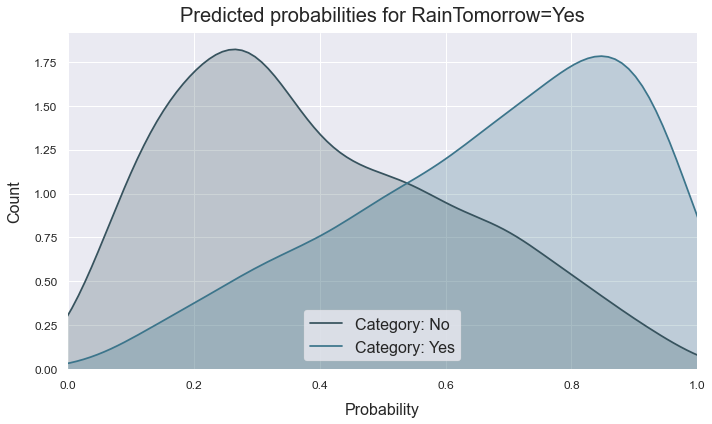

In [10]:
# The probabilties plot shows the distribution of predicted
# probabilities for the positive class
atom.winner.plot_probabilities()

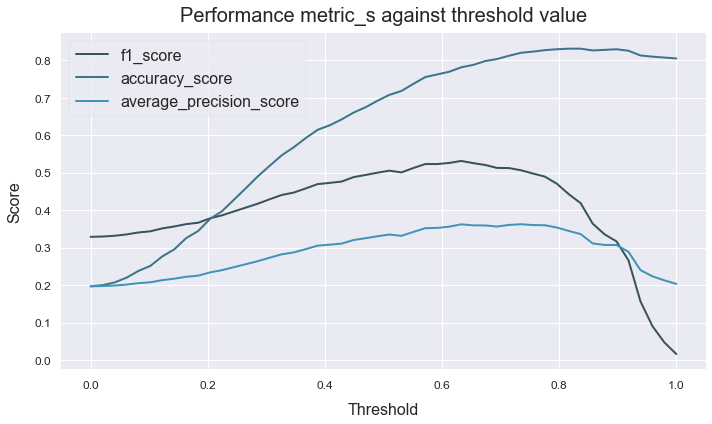

In [11]:
# The threshold plot let us compare how different metrics
# perform for different thresholds
atom.winner.plot_threshold(metric=['f1', 'accuracy', 'average_precision'], steps=50, filename='thresholds.png')

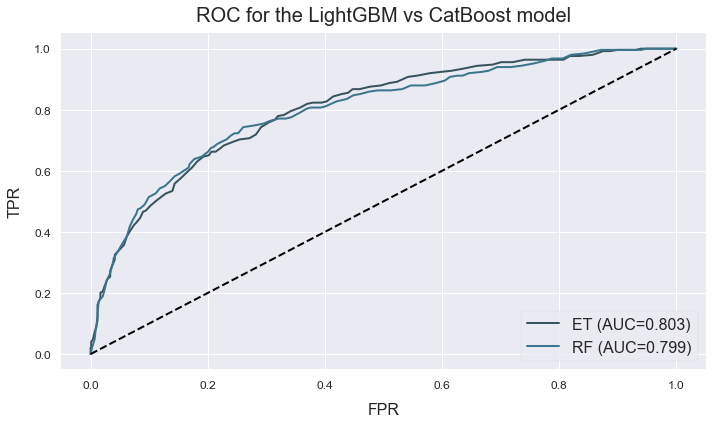

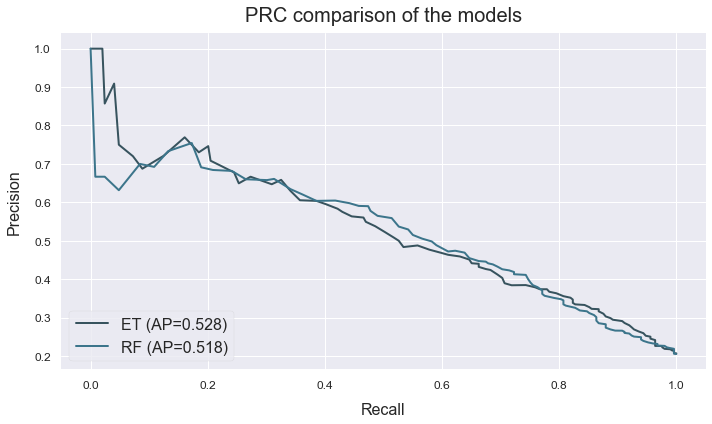

In [12]:
# The ROC and PRC curve are also typical ways of measuring performance 
atom.plot_roc(title="ROC for the LightGBM vs CatBoost model")
atom.plot_prc(title="PRC comparison of the models")